In [148]:
import pandas as pd
import numpy as np
from datetime import datetime
from openpyxl import load_workbook
import string, re

In [149]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
%matplotlib inline
plt.style.use('ggplot')

In [150]:
df = pd.read_csv("./data/EniShell_transformed.csv", sep="¬")

/home/katia/.virtualenvs/securaxis/lib/python3.5/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [151]:
df.company.value_counts()

SPDC    865
NAOC    721
Name: company, dtype: int64

### 1. Main Oil Trends

#### * number of spills per company per year

In [152]:
# make sure all JIV numbers are unique
df.jiv_asset_id.value_counts().head()

Missing JIV    8
640            1
476            1
965            1
1309           1
Name: jiv_asset_id, dtype: int64

There are 8 reported oil spills with missing JIVs - investigate whether they differ

In [153]:
df[df.jiv_asset_id == "Missing JIV"].head(3)

,Unnamed: 0,oil_spill_id,company,jiv_number,date_reported,year,date_jiv_shell,facility_equipment,terrain,cause,...,damage_photo_followup,comment_jiv_duplicate,comment_jiv_text,inches,facility_type,location,facility_name,facility_start,facility_end,cause_mapped
111,111,17,SPDC,NaN,2016-11-01,2016,2016-11-04,18'' Assa-Rumuekpe Pipeline at Egbeda,Land,Sabotage,...,Missing poto,NaN,NaN,18.0,pipeline,egbeda,assa - rumuekpe,assa,rumuekpe,sabotage/theft
455,455,327,SPDC,NaN,2017-01-21,2017,2017-03-10,12'' Imo River-Ogale Pipeline at Komkom,Land,Sabotage,...,Missing poto,NaN,NaN,12.0,pipeline,komkom,imo river - ogale,imo river,ogale,sabotage/theft
611,611,135,SPDC,NaN,2013-05-02,2013,2013-05-03,4'' Adibawa North East Well 1L Flowline at Biseni,Land,Sabotage/ Theft,...,Missing poto,NaN,NaN,4.0,"flowline, well",biseni,adibawa north east well 1l,NaN,NaN,sabotage/theft


* get incident date year 

In [154]:
df.date_incident = pd.to_datetime(df.date_incident, format="%Y-%m-%d %H:%M:%S", errors="coerce")

In [155]:
df["year_incident"] = df.date_incident.map(lambda x: x.year)

In [156]:
df[["company", "year", "oil_spill_id"]].groupby(["company", "year"]).count()

oil_spill_id
company year              
NAOC    2014           350
        2015           196
        2016           164
        2017            11
SPDC    2011           143
        2012           170
        2013           180
        2014           175
        2015           131
        2016            58
        2017             8

In [157]:
# write to excel
stats_file = './data/Statistics.xlsx'
writer = pd.ExcelWriter(stats_file)
df[["company", "year", "oil_spill_id"]].groupby(["company", "year"]).count().to_excel(writer,'No._Spills_Per_year_per_Company')
writer.close()

In [158]:
def update_excel(new_df, sht_name):
    book = load_workbook(stats_file)

    writer = pd.ExcelWriter(stats_file, engine = 'openpyxl')
    writer.book = book

    new_df.to_excel(writer, sheet_name = sht_name)
    writer.save()
    writer.close()

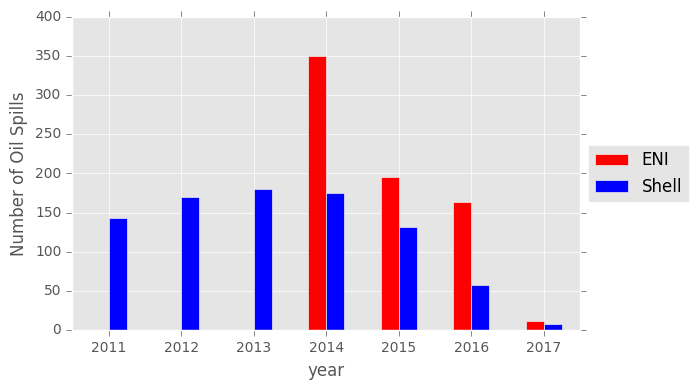

In [159]:
df[["oil_spill_id","company", "year"]]\
    .groupby( ["year", "company"] ).count()\
    .unstack("company")\
    .plot(kind="bar",
          color=["#ff0000", "#0000ff"])\
    .legend(
            ["ENI", "Shell"], 
            loc='center left',
            bbox_to_anchor=(1, 0.5)
        )

plt.ylim([0,400])
plt.xticks(rotation=0)    
plt.ylabel("Number of Oil Spills")
plt.tight_layout()
plt.savefig('./images/No_Spills_per_Company_per_Year.png', bbox_inches='tight', pad_inches=0)

#### * cause of spills per company per year - as of JIV

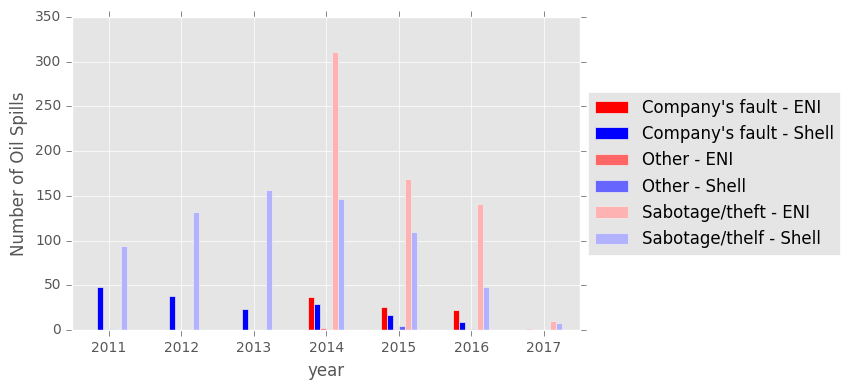

In [160]:
df[["oil_spill_id","company", "year", "cause_mapped"]]\
    .groupby( ["year", "cause_mapped", "company"] ).count()\
    .unstack("cause_mapped")\
    .unstack("company")\
    .plot(kind="bar",
          color=["#ff0000", "#0000ff", "#ff6666", "#6666ff", "#ffb2b2", "#b2b2ff"])\
    .legend(
            ["Company's fault - ENI", "Company's fault - Shell", "Other - ENI", "Other - Shell", "Sabotage/theft - ENI", "Sabotage/thelf - Shell"], 
            loc='center left',
            bbox_to_anchor=(1, 0.5)
        )

plt.xticks(rotation=0)    
plt.ylabel("Number of Oil Spills")
plt.tight_layout()
plt.savefig('./images/CauseMapped_per_Company_per_Year.png', bbox_inches='tight', pad_inches=0)

In [161]:
update_excel(df[["oil_spill_id","company", "year", "cause_mapped"]]\
    .groupby( ["year", "cause_mapped", "company"] ).count(),
            "Cause_Mapped_per_Comp_per_Year")

In [162]:
update_excel(df[["oil_spill_id","company", "year", "cause"]]\
    .groupby( ["year", "cause", "company"] ).count(),
                 "Cause_per_Company_per_year")

#### * volume of spills per company

In [163]:
barrels_company_year = df[["company", "year", "barrels"]]\
    .groupby( ["year", "company"] ).sum()\
    .unstack("company")
barrels_company_year.columns = ["Eni", "Shell"]
barrels_company_year

total_barrels = df[["company", "year", "barrels"]]\
    .groupby( ["year", "company"] ).sum().sum().iloc[0]


In [164]:
barrels_company_year["Eni %"] = barrels_company_year.Eni.divide(total_barrels)*100
barrels_company_year["Shell %"] = barrels_company_year.Shell.divide(total_barrels)*100

update_excel(barrels_company_year, "Barrels_per_Comp_per_Year")
barrels_company_year

,Eni,Shell,Eni %,Shell %
year,,,,
2011,NaN,4686.8210,NaN,4.286022
2012,NaN,22364.4143,NaN,20.451895
2013,NaN,21052.9280,NaN,19.252562
2014,7176.447,14758.0030,6.562745,13.495955
2015,11211.561,17963.0500,10.252791,16.426919
2016,4338.260,5343.5000,3.967269,4.886544
2017,219.620,236.7000,0.200839,0.216458


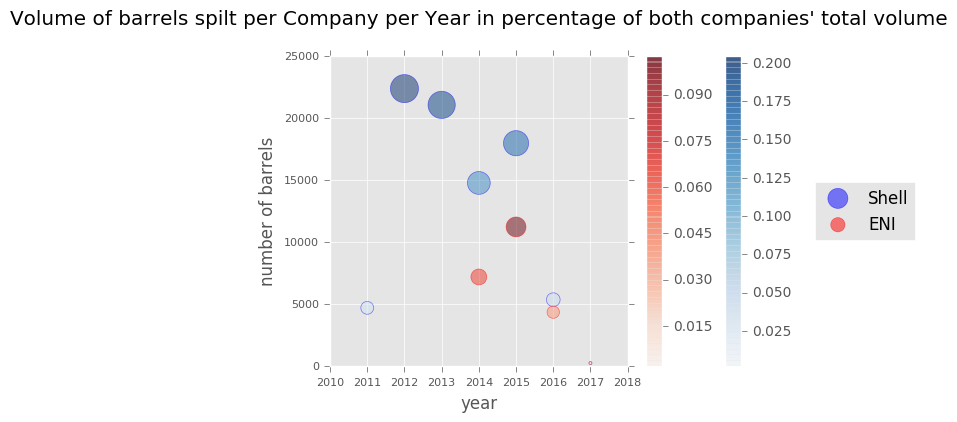

In [165]:
x = [2011, 2012, 2013, 2014, 2015, 2016, 2017]
factor = 2000

#Shell
y_Shell = list(barrels_company_year.Shell)
area_Shell = barrels_company_year.Shell.divide(total_barrels) * factor
z_Shell = list(barrels_company_year.Shell.divide(total_barrels))
cm_Shell = plt.cm.get_cmap("Blues")

#ENI
y_Eni = list(barrels_company_year.Eni)
area_Eni = barrels_company_year.Eni.divide(total_barrels) * factor
z_Eni = list(barrels_company_year.Eni.divide(total_barrels))
cm_Eni = plt.cm.get_cmap("Reds")

fig, ax = plt.subplots()
sc_Shell = ax.scatter(x,y_Shell,s=area_Shell,c=z_Shell,cmap=cm_Shell,alpha=0.5,linewidths=0.5, edgecolor='b')
fig.colorbar(sc_Shell)


sc_Eni = ax.scatter(x,y_Eni,s=area_Eni,c=z_Eni,cmap=cm_Eni,alpha=0.5,linewidths=0.5, edgecolor='r')
fig.colorbar(sc_Eni)
# adjust plot's looks
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel("year")
plt.ylabel("number of barrels")
plt.ylim([0,25000])
plt.legend(
            ["Shell", "ENI"], 
            loc='center left',
            bbox_to_anchor=(1.6, 0.5),
            scatterpoints=1 # regulates the number of markers on the legend
        )
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')

plt.title("Volume of barrels spilt per Company per Year in percentage of both companies' total volume", y=1.08)
plt.savefig('./images/Barrels_Split_per_Company_per_Year.png', bbox_inches='tight', pad_inches=0)

plt.show()

#### * volume per cause

In [166]:
volume_per_cause = df[["company", "cause_mapped", "barrels"]]\
    .groupby( ["cause_mapped", "company"] ).sum()\
    .unstack("company")
volume_per_cause.columns = ["Eni", "Shell"]
volume_per_cause["Both"] = volume_per_cause.Eni + volume_per_cause.Shell

update_excel(volume_per_cause, "Volume_per_Company_per_Cause_Mapped")
volume_per_cause

/home/katia/.virtualenvs/securaxis/lib/python3.5/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


,Eni,Shell,Both
cause_mapped,,,
company's fault,1631.840,9122.4300,10754.2700
other,73.810,1438.8000,1512.6100
sabotage/theft,21240.238,75844.1863,97084.4243


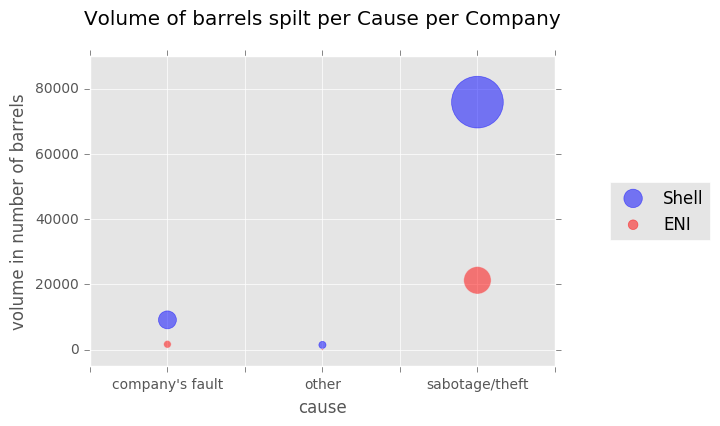

In [167]:
x = [10,20,30]
x_tick_labels = ["", "company's fault", "", "other", "", "sabotage/theft"]
factor = 2000

#Shell
y_Shell = list(volume_per_cause.Shell)
area_Shell = volume_per_cause.Shell.divide(total_barrels) * factor
z_Shell = list(volume_per_cause.Shell.divide(total_barrels))

#ENI
y_Eni = list(volume_per_cause.Eni)
area_Eni = volume_per_cause.Eni.divide(total_barrels) * factor
z_Eni = list(volume_per_cause.Eni.divide(total_barrels))

fig, ax = plt.subplots()
# Shell plot
sc_Shell = ax.scatter(x,y_Shell,s=area_Shell,color='blue',alpha=0.5,linewidths=0.5)
# Eni plot
sc_Eni = ax.scatter(x,y_Eni,s=area_Eni,c="red",alpha=0.5,linewidths=0.5)

# adjust join plot
ax.set_xticklabels(x_tick_labels)
plt.ylim([-5000,90000])

plt.legend(
            ["Shell", "ENI"], 
            loc='center left',
            bbox_to_anchor=(1.1, 0.5),
            markerscale=0.5,
            scatterpoints=1
        )
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')

plt.xlabel("cause")
plt.ylabel("volume in number of barrels")
plt.title("Volume of barrels spilt per Cause per Company", y=1.08)
plt.savefig('./images/Cause_per_Company.png', bbox_inches='tight', pad_inches=0)

plt.show()

#### * averages in responce time

In [168]:
# transform date columns
df.date_reported = pd.to_datetime(df.date_reported, format="%Y-%m-%d")
df.date_investigation_start[df.date_investigation_start == "Missing JIV"] = np.nan
df.date_investigation_start = pd.to_datetime(df.date_investigation_start, format="%Y-%m-%d %H:%M:%S")
df.date_jiv_shell = pd.to_datetime(df.date_jiv_shell, format="%Y-%m-%d")
df.date_reported = pd.to_datetime(df.date_reported, format="%Y-%m-%d")

/home/katia/.virtualenvs/securaxis/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [169]:
df["response_time"] = df.date_investigation_start - df.date_reported

In [170]:
df.response_time.value_counts().head()

0 days    450
1 days    300
2 days    238
3 days    131
4 days    100
Name: response_time, dtype: int64

In [171]:
update_excel(df[["oil_spill_id", "jiv_asset_id"]][df.response_time < "0 days"], "Negative_Date_Investigation_Minus_Date_Reported")
df[["oil_spill_id", "jiv_asset_id"]][df.response_time < "0 days"]

/home/katia/.virtualenvs/securaxis/lib/python3.5/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


,oil_spill_id,jiv_asset_id
28,809,2143
81,1410,2664
109,740,1787
132,827,2228
254,828,2442
286,1006,2606
312,785,1957
519,1403,2629
539,1259,1927
619,683,1693


Observation: there are - reposting times.

In [172]:
df[df.response_time == "-26 days"]

,Unnamed: 0,oil_spill_id,company,jiv_number,date_reported,year,date_jiv_shell,facility_equipment,terrain,cause,...,comment_jiv_text,inches,facility_type,location,facility_name,facility_start,facility_end,cause_mapped,year_incident,response_time
1382,1382,39,SPDC,683734,2011-07-03,2011,2011-07-07,Ubie Well 4S Flowline at Ubie,Land,Sabotage/ Theft,...,"Date is not clear, hard to determine if the da...",NaN,"flowline, well",ubie,ubie well 4s,NaN,NaN,sabotage/theft,2011.0,-26 days


Investigation: the scanned document for the above example is ambigous, try looking at more...

In [173]:
df[df.response_time == "-9 days"]

,Unnamed: 0,oil_spill_id,company,jiv_number,date_reported,year,date_jiv_shell,facility_equipment,terrain,cause,...,comment_jiv_text,inches,facility_type,location,facility_name,facility_start,facility_end,cause_mapped,year_incident,response_time
519,519,1403,NAOC,SAR-261-416-986,2015-11-13,2015,NaT,Taylor Creek 2Ls flowline,Land,Hacksaw cut,...,The team observed 5mm long rupture due to sand...,NaN,flowline,Yenagoa,taylor creek 2ls,NaN,NaN,sabotage/theft,2015.0,-9 days


In [174]:
df[df.response_time == "-3 days"]

,Unnamed: 0,oil_spill_id,company,jiv_number,date_reported,year,date_jiv_shell,facility_equipment,terrain,cause,...,comment_jiv_text,inches,facility_type,location,facility_name,facility_start,facility_end,cause_mapped,year_incident,response_time
132,132,827,SPDC,1200680,2014-06-24,2014,2014-06-21,28'' Bomu - Bonny Pipeline at Owokiri,Swamp,Sabotage,...,NaN,28.0,pipeline,owokiri,bomu - bonny,bomu,bonny,sabotage/theft,2014.0,-3 days
1158,1158,843,SPDC,1489792,2015-09-22,2015,2015-09-19,12'' Adibawa-Okordia Pipeline at Ikarama,Land,Sabotage,...,NaN,12.0,pipeline,ikarama,adibawa - okordia,adibawa,okordia,sabotage/theft,2015.0,-3 days


Conclusion after looking at data: use date_incident and date_investigation_start

In [175]:
df['response_time_in_days'] = (df.date_investigation_start - df.date_incident).dt.days

#### * top 10 worst incidents in terms of response time

In [176]:
df.company.value_counts().divide(df.shape[0])

SPDC    0.545397
NAOC    0.454603
Name: company, dtype: float64

In [177]:
update_excel(df.response_time_in_days.sort_values(ascending=False).head(10).to_frame(name='Response Time in Days'), "Top_10_Worst_Response_Time_Accidents")
df.response_time.sort_values(ascending=False).head(10)

/home/katia/.virtualenvs/securaxis/lib/python3.5/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


1043   430 days
1542   190 days
317    180 days
1122   156 days
1078   123 days
222    113 days
797    107 days
1125    86 days
129     76 days
164     62 days
Name: response_time, dtype: timedelta64[ns]

In [178]:
df[["jiv_number", "location"]][df.response_time_in_days == 430]

,jiv_number,location
1043,SAR-241-387-107,Nembe


#### * plot only top 200 worst response times

In [179]:
update_excel(df[["oil_spill_id", "company", "response_time", "response_time_in_days"]], "All_Response_Times")

/home/katia/.virtualenvs/securaxis/lib/python3.5/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [180]:
df[df.response_time_in_days > 2].shape

(652, 56)

In [181]:
values = df.response_time_in_days.sort_values(ascending=False).head(100)
top_hunderd = pd.Series(values).value_counts()
x_labels = top_hunderd.index
x = list(top_hunderd)

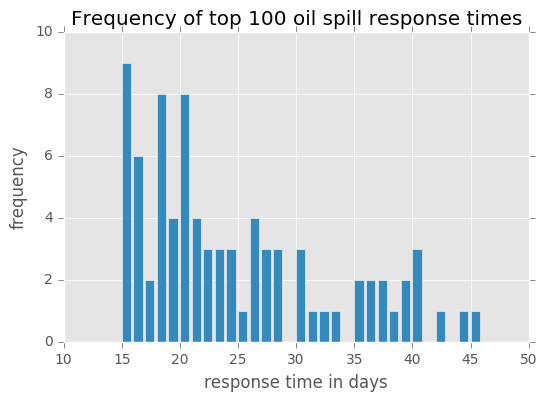

In [182]:
plt.bar(x_labels, x)
plt.ylim([0, 10])
plt.xlim([10,50])

plt.xlabel("response time in days")
plt.ylabel("frequency")
plt.title("Frequency of top 100 oil spill response times")

plt.savefig('./images/Top_response_times.png')

#### * alanlyse 3 main producing states in Nigeria

In [183]:
lgas = pd.read_csv("./data/Nigerian_settlements.csv")

In [184]:
del lgas["Unnamed: 0"]

In [185]:
lgas

,settlement,state,lga,settlement_lower
0,(( Bendel State )),Edo,Orhionmwon,(( bendel state ))
1,(( Benue-Plateau St*,Benue,Guma,(( benue-plateau st*
2,(( Gongola State )),Taraba,Bali,(( gongola state ))
3,(( North-Western St*,Kebbi,Sakaba,(( north-western st*
4,(( Western State )),Oyo,Lagelu,(( western state ))
5,─Çng─½go,Borno,Kala/Balge,─çng─½go
6,3,Federal Capital Territory,Bwari,3
7,A Ata Hill,Ekiti,Ikere,a ata hill
8,Aabom,Rivers,Eleme,aabom
9,Aakaa,Benue,Ushongo,aakaa


In [186]:
settlement_set = set()
lga_set = set()

In [187]:
lgas["lga_lower"] = lgas.lga.str.lower()

In [188]:
for settl in lgas.settlement_lower:
    settlement_set.add(re.sub('['+string.punctuation+']', '', settl).strip())
    
for lg in lgas.lga.str.lower():
    if type(lg) != float:
        lga_set.add(re.sub('['+string.punctuation+']', '', lg).strip())

In [189]:
states = [np.nan] * df.shape[0]
df.location = df.location.str.lower()

for i in range(df.shape[0]):
    company = df.company.iloc[i]
    company = df.company.iloc[i]
    location_as_is = df.location.iloc[i]
    if type(location_as_is) != float:
        locs = re.split(r'[`\-=~!@#$%^&*()_+\[\]{};\'\\:"|<,./<>?]', location_as_is)
        state = ""
        
        for loc in locs:
            if loc in settlement_set and lgas.state[lgas.settlement_lower == loc].shape[0] > 0:
                if type(lgas.state[lgas.settlement_lower == loc].iloc[0]) != float:
                    state += lgas.state[lgas.settlement_lower == loc].iloc[0] + " "
            
            if state == "":   
                if loc in lga_set and lgas.state[lgas.lga_lower == loc].shape[0] > 0:
                    if type(lgas.state[lgas.lga_lower == loc].iloc[0]) != float:
                        state += lgas.state[lgas.lga_lower == loc].iloc[0] + " "

    states[i] = (np.nan if state.strip() == "" else state.strip())
            
df["states"] = pd.Series(states).values

In [190]:
df.states.isnull().sum()

455

In [98]:
df[["states", "company"]].groupby(["company"]).count()

,states
company,
NAOC,705
SPDC,426


In [191]:
df.location.head()

0      abua/odual
1          komkom
2        edagberi
3    okolo launch
4         oporoma
Name: location, dtype: object

In [202]:
del df['Unnamed: 0']

In [203]:
df.to_csv("./data/EniShell_transformed.csv", sep="¬")

In [204]:
df1 = pd.read_csv("./data/EniShell_transformed.csv", sep="¬")

/home/katia/.virtualenvs/securaxis/lib/python3.5/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


### 2. Investigate pipelines

#### * normalize facility names more

In [207]:
df = pd.read_csv("./data/EniShell_transformed.csv", sep="¬")
del df['Unnamed: 0']

/home/katia/.virtualenvs/securaxis/lib/python3.5/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [208]:
update_excel(df.facility_name.value_counts().to_frame(name='Number of Spills'), "Pipelines_With_Most_Spills")
df.facility_name.value_counts().head(10)

/home/katia/.virtualenvs/securaxis/lib/python3.5/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


tebidaba - brass           265
clough creek - tebidaba    115
nkpoku - bomu              106
bomu - bonny                66
ogboinbiri - tebidaba       51
imo river - ogale           32
assa - rumuekpe             27
otumara - escravos          27
taylor creek 2ls            21
taylor creek 2ss            20
Name: facility_name, dtype: int64

#### * breakdown by cause

In [209]:
df[["oil_spill_id", "cause_mapped", "facility_name"]]\
.groupby(["cause_mapped", "facility_name"])\
.count()\
.nlargest(10, columns=["oil_spill_id"])

oil_spill_id
cause_mapped   facility_name                        
sabotage/theft tebidaba - brass                  263
               clough creek - tebidaba           108
               nkpoku - bomu                      98
               bomu - bonny                       59
               ogboinbiri - tebidaba              43
               imo river - ogale                  32
               otumara - escravos                 27
               assa - rumuekpe                    25
               taylor creek 2ls                   21
               taylor creek 2ss                   18

In [210]:
df[["oil_spill_id", "cause", "facility_name"]]\
.groupby(["cause", "facility_name"])\
.count()\
.nlargest(10, columns=["oil_spill_id"])

oil_spill_id
cause           facility_name                        
Oil theft       tebidaba - brass                  241
                clough creek - tebidaba            90
Sabotage        nkpoku - bomu                      72
                bomu - bonny                       51
Oil theft       ogboinbiri - tebidaba              31
Sabotage        otumara - escravos                 26
Sabotage/ Theft nkpoku - bomu                      26
Sabotage        otumara - escravos                 26
Sabotage/ Theft nkpoku - bomu                      26
Sabotage        imo river - ogale                  25
Hacksaw cut     taylor creek 2ls                   19
                taylor creek 2ss                   15
Sabotage        nembe creek                        15

In [211]:
update_excel(df[["oil_spill_id", "cause_mapped", "facility_name"]]\
.groupby(["cause_mapped", "facility_name"])\
.count(), "Pipeline Spill Count per Cause")

/home/katia/.virtualenvs/securaxis/lib/python3.5/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


df[["oil_spill_id", "cause", "facility_name"]]\
.groupby(["cause", "facility_name"])\
.count()\
.nlargest(10, columns=["oil_spill_id"])

In [212]:
df[["oil_spill_id", "cause_amnesty", "facility_name"]]\
.groupby(["cause_amnesty", "facility_name"])\
.count()\
.nlargest(10, columns=["oil_spill_id"])

oil_spill_id
cause_amnesty              facility_name                        
Third party (theft)        tebidaba - brass                  231
                           clough creek - tebidaba            90
                           nkpoku - bomu                      56
                           bomu - bonny                       47
                           imo river - ogale                  31
                           ogboinbiri - tebidaba              31
                           imo river - ogale                  31
                           ogboinbiri - tebidaba              31
                           otumara - escravos                 25
Third party (undetermined) nkpoku - bomu                      25
Third party (theft)        otumara - escravos                 25
Third party (undetermined) nkpoku - bomu                      25
Undetermined               nkpoku - bomu                      19
Operational                tebidaba - brass                   17

In [213]:
update_excel(df[["oil_spill_id", "cause_mapped", "facility_name"]]\
.groupby(["cause_mapped", "facility_name"])\
.count(), "Pipeline Spill Count per Cause")

/home/katia/.virtualenvs/securaxis/lib/python3.5/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


### * investigate connection between cause_mapped and cause_amnesty

In [214]:
df.cause_amnesty.value_counts()

Third party (theft)                 772
Third party (undetermined)          312
Operational                         303
Undetermined                        195
Third party (accident)                3
Operational; Third party (theft)      1
Name: cause_amnesty, dtype: int64

In [215]:
df[["oil_spill_id", "cause_mapped", "cause_amnesty"]]\
.groupby(["cause_mapped", "cause_amnesty"])\
             .count()

oil_spill_id
cause_mapped    cause_amnesty                                 
company's fault Operational                                228
                Operational; Third party (theft)             1
                Third party (accident)                       1
                Third party (theft)                          2
                Third party (undetermined)                   5
                Undetermined                                13
other           Operational                                  2
                Third party (accident)                       2
                Third party (undetermined)                   1
                Undetermined                                 5
sabotage/theft  Operational                                 73
                Third party (theft)                        770
                Third party (undetermined)                 306
                Undetermined                               177

In [216]:
df.cause_mapped.value_counts()

sabotage/theft     1326
company's fault     250
other                10
Name: cause_mapped, dtype: int64

### Damage to Previous Repair

In [232]:
df.comment_type_jiv.value_counts()

Additional info              519
Damage to previous repair    120
Inconsistencies               46
Outstanding Findings          17
Name: comment_type_jiv, dtype: int64

In [225]:
facility_name_percentage = df.facility_name.value_counts().divide(df.shape[0])*100

In [233]:
damage_facility = df[df.comment_type_jiv == "Damage to previous repair"][["oil_spill_id", "facility_name"]]\
.groupby("facility_name").count()
damage_facility["expected distribution in %"] = facility_name_percentage[damage_facility.index]
damage_facility["distribution of damage repairs in %"] = damage_facility.oil_spill_id.divide(df.comment_type_jiv.value_counts()["Damage to previous repair"])
damage_facility

,oil_spill_id,expected distribution in %,distribution of damage repairs in %
facility_name,,,
122 back,1,0.063052,0.008333
14'' ogboinbiri/tebidaba pipeline & 6'' azuzuama /tebidaba,1,0.063052,0.008333
azuzuama - tebidaba,1,0.252207,0.008333
bomu - bomu,1,0.252207,0.008333
bomu - bonny,1,4.161412,0.008333
clough creek - tebidaba,5,7.250946,0.041667
obama - brass,3,0.882724,0.025000
obiafu 5t,1,0.063052,0.008333
ogboinbiri - tebidaba,7,3.215637,0.058333


In [235]:
damage_facility.columns = ["count", "expected distribution in %", "distribution of damage repairs in %"]
update_excel(damage_facility, "Damage to Previous Repair")

/home/katia/.virtualenvs/securaxis/lib/python3.5/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [236]:
damage_cause = df[df.comment_type_jiv == "Damage to previous repair"][["oil_spill_id", "cause"]]\
.groupby("cause").count()
damage_cause.columns = ["count"]
damage_cause

,count
cause,
Equipment failure,12
Hacksaw cut,1
Oil theft,101
Operational,1
Sabotage,1
Use of explosive,2
Vandalization,2


In [237]:
update_excel(damage_cause, "Damage Prev Repair <> Cause")

/home/katia/.virtualenvs/securaxis/lib/python3.5/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [241]:
damage_cause_am = df[df.comment_type_jiv == "Damage to previous repair"][["oil_spill_id", "cause_amnesty", "company"]]\
.groupby(["cause_amnesty", "company"]).count()
damage_cause_am

oil_spill_id
cause_amnesty              company              
Operational                NAOC               16
                           SPDC                1
Third party (theft)        NAOC              100
                           SPDC                1
Third party (undetermined) NAOC                2

In [242]:
update_excel(damage_cause, "Damage Prev Repair <> Cause Decoders")

/home/katia/.virtualenvs/securaxis/lib/python3.5/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [247]:
damage_terrain = df[df.comment_type_jiv == "Damage to previous repair"][["oil_spill_id", "terrain", "company"]]\
.groupby(["terrain", "company"]).count()
damage_terrain.columns = ["count"]
damage_terrain

count
terrain company       
Land    NAOC         5
Swamp   NAOC       113
        SPDC         2

#### * investigate time lapse between repairs for ebidaba - Brass

In [284]:
damage_date.head()

,oil_spill_id,company,date_incident,location,date_to_substract_from
282,1070,NAOC,2014-01-07,southern ijaw,2014-01-22
636,1526,NAOC,2014-01-22,southern ijaw,2014-01-23
1104,1533,NAOC,2014-01-23,southern ijaw,2014-01-24
1012,1545,NAOC,2014-01-24,southern ijaw,2014-01-29
1226,1582,NAOC,2014-01-29,southern ijaw,2014-02-26


In [298]:
damage_date = df[["oil_spill_id", "company", "date_incident", "location", "barrels"]][(df.comment_type_jiv == "Damage to previous repair") & (df.facility_name == "tebidaba - brass")].sort_values("date_incident")
last_date = damage_date.date_incident.iloc[damage_date.shape[0]-1]
move_one_down_date_series = damage_date.date_incident.set_value(2000, last_date).iloc[1:] # sets index value & column value
move_one_down_date_series.index = damage_date.index
damage_date["date_to_substract_from"] = move_one_down_date_series
damage_date.date_incident = pd.to_datetime(damage_date.date_incident, format="%Y-%m-%d")
damage_date.date_to_substract_from = pd.to_datetime(damage_date.date_to_substract_from, format="%Y-%m-%d")
damage_date["timelapse_between_damage_spills"] = (damage_date.date_to_substract_from - damage_date.date_incident).dt.days
damage_date

,oil_spill_id,company,date_incident,location,barrels,date_to_substract_from,timelapse_between_damage_spills
282,1070,NAOC,2014-01-07,southern ijaw,53.00,2014-01-22,15
636,1526,NAOC,2014-01-22,southern ijaw,10.00,2014-01-23,1
1104,1533,NAOC,2014-01-23,southern ijaw,3.00,2014-01-24,1
1012,1545,NAOC,2014-01-24,southern ijaw,4.00,2014-01-29,5
1226,1582,NAOC,2014-01-29,southern ijaw,2.00,2014-02-26,28
1189,1481,NAOC,2014-02-26,oyeregbene,2.50,2014-03-10,12
1233,1269,NAOC,2014-03-10,southern ijaw,2.00,2014-03-27,17
1237,1552,NAOC,2014-03-27,southern ijaw,2.00,2014-03-27,0
462,1560,NAOC,2014-03-27,southern ijaw,20.00,2014-03-29,2
1406,1568,NAOC,2014-03-29,southern ijaw,1.00,2014-03-29,0


In [299]:
update_excel(damage_date, "Time Lapse in Days between Damage in Prev Repair - Eni")

/home/katia/.virtualenvs/securaxis/lib/python3.5/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [300]:
damage_date[damage_date.timelapse_between_damage_spills < 5]

,oil_spill_id,company,date_incident,location,barrels,date_to_substract_from,timelapse_between_damage_spills
636,1526,NAOC,2014-01-22,southern ijaw,10.0,2014-01-23,1
1104,1533,NAOC,2014-01-23,southern ijaw,3.0,2014-01-24,1
1237,1552,NAOC,2014-03-27,southern ijaw,2.0,2014-03-27,0
462,1560,NAOC,2014-03-27,southern ijaw,20.0,2014-03-29,2
1406,1568,NAOC,2014-03-29,southern ijaw,1.0,2014-03-29,0
463,1564,NAOC,2014-03-29,southern ijaw,20.0,2014-03-30,1
1238,1575,NAOC,2014-03-30,southern ijaw,2.0,2014-04-01,2
143,1265,NAOC,2014-04-07,southern ijaw,150.0,2014-04-07,0
1408,1345,NAOC,2014-04-07,southern ijaw,1.0,2014-04-08,1
736,1422,NAOC,2014-05-16,southern ijaw,8.0,2014-05-17,1


#### * damage to previous repair and barrels leaked

In [310]:
damage_barrels = df[["barrels", "company"]][(df.comment_type_jiv == "Damage to previous repair")]
damage_barrels[["barrels", "company"]].groupby(["company"])\
.sum()


,barrels
company,
NAOC,2317.11
SPDC,6.00
